In [15]:
import os
import glob
from typing import Tuple, List, Union

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

# bookmaker -- An NBA Deep Learning Prediction Model

## Problem Formulation & Motivation

In May of 2018, the U.S. Supreme Court ruled that individual states had the right to legalize sports betting, overturning a longstanding law. Since then, dozens of states have introduced legislation to allow betting sites to operate within their borders, and the cumulative value of the American sports betting market is expected to reach \$8 billion by 2025.

Anecdotally, betting lines are remarkably accurate at predicting outcomes, but as an aggregation of human opinions, they are inherently biased. We believe that we can improve on these group-think predictions by taking a data-driven approach towards odds making. Traditional NBA forecast models use team-based statistics to predict the outcome of games. Here, we've designed a deep learning system that utilizes individualized player data in addition to conventional game statistics to generate more accurate forecasts of team point production in a given match-up.

## Data Sources & Pre-Processing

Constructing the input features of our model required significant pre-processing of our raw data. The raw data was sourced from three primary stores, and covered the years 2015-2020.

1. `NBA.com`
2. `FiveThirtyEight.com`
3. `sportsbookreviewsonline.com`

We scraped raw box score data from `NBA.com` on a per-game basis by a pre-processing script. From `FiveThirtyEight`, we pulled their proprietary RAPTOR data. The `sportsbookreviewsonline` websites hosts Excel files of historical odds data, which we downloaded directly.

We reserved the 2020 season as a `test` year, 2019 as a `validation` year, and the remainder as `train` years.

In [16]:
example_file = os.path.join('data', 'raw', '2015-nba-boxscores.csv')
boxscore_data = pd.read_csv(example_file, index_col=0)
boxscore_data.sample(5)

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
21850,21400370,1610612737,ATL,Atlanta,203488,Mike Muscala,NaN,NaN,4:41,2.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,5.0
2470,21401128,1610612752,NYK,New York,203495,Ricky Ledo,NaN,NaN,31:38,6.0,...,3.0,6.0,9.0,3.0,1.0,0.0,1.0,3.0,21.0,9.0
4049,21401073,1610612754,IND,Indiana,101139,CJ Miles,G,NaN,32:11,7.0,...,1.0,2.0,3.0,1.0,1.0,0.0,2.0,3.0,26.0,-4.0
10857,21400803,1610612753,ORL,Orlando,203095,Evan Fournier,F,NaN,38:44,7.0,...,0.0,6.0,6.0,3.0,0.0,0.0,0.0,1.0,16.0,19.0
19747,21400453,1610612739,CLE,Cleveland,2217,Brendan Haywood,NaN,NaN,7:49,3.0,...,0.0,3.0,3.0,0.0,0.0,0.0,1.0,0.0,7.0,-3.0


In [17]:
example_file = os.path.join('data', 'raw', 'odds-2014-15.xlsx')
odds_data = pd.read_excel(example_file)
odds_data.head(10)

,Date,Rot,VH,Team,1st,2nd,3rd,4th,Final,Open,Close,ML,2H
0,1028,501,V,Dallas,24,29,20,27,100,206.5,203.5,140,102
1,1028,502,H,SanAntonio,26,19,31,25,101,6,3.5,-165,4
2,1028,503,V,Orlando,25,16,23,20,84,196,191,380,94.5
3,1028,504,H,NewOrleans,24,24,30,23,101,9.5,9,-475,3.5
4,1028,505,V,Houston,31,31,23,23,108,6.5,7,-300,103
5,1028,506,H,LALakers,19,26,24,21,90,209,207,250,1.5
6,1029,701,V,Milwaukee,24,33,26,17,106,192,193,315,97
7,1029,702,H,Charlotte,25,21,22,32,108,9,8,-390,7.5
8,1029,703,V,Philadelphia,24,27,19,21,91,194,189.5,290,95
9,1029,704,H,Indiana,26,22,30,25,103,8.5,7.5,-350,6


Historical player statistics are typically calculated on a per-season basis. One could use a player's prior season statistics, but this quickly become stale and fail to capture improvements player's make throughout a season. To remedy this, we manually computed "live" statistics. In our pre-processing, we essentially constructed a massive hash table where you could look up current statistics for any date/player pair.

Additionally, the raw odds data was very unstructed and required significant cleaning.

## Model Features and Architecture

We chose to have our model predict the points scored for a single team in a given matchup. One benefit of this decision is that it effectively doubles our training data, since each game results in two observations. Additionally, it gives us some flexibility in evaluating our model. With a predicted score for each team, we can form predictions of both the `spread` and the `over/under`. 

The downside is that our model is not explicitly trained to perfrom well on predicting either the `spread` **or** the `over/under`. 

We limited our analysis to the five starting players, plus a "top" sub defined by minutes played. Doing so could potentially cause a situation where one team's starters have "better" absolute stats simply by playing more minutes. To account for this, we standarized all statistics per 48 minutes. The final features for our model are as follows:
* `this` - (team we are predicting)
    * C1
        * PTS
        * ASTS
        * OREBS
        * FGM
        * FGA
        * FG3M
        * FG3A
        * FTM
        * FTA
    * G1
    * G2
    * F1
    * F2
    * S1
* `other` - (team we are playing against)
    * C1
        * STL
        * DREB
        * BLK
        * TO
    * G1
    * G2
    * F1
    * F2
    * S1
    
For a total of `(6 * 9) + (6 * 4) = 78` total features. All features are Z-score normalized before being piped to the network. This transforms all our features to a comparable scale, and improves the performance of gradient descent.

In [18]:
def load_model_data(_type: str) -> Tuple[pd.MultiIndex, torch.tensor, torch.tensor]:
    """
    Retrieve features and score outcomes from the proper data directory so 
    we can feed them into a PyTorch model.
    
    Parameters:
        _type: Choose from {'train', 'dev', 'test'}
        
    Returns:
        A 3-tuple consisting of
            1) A pd.MultiIndex so we can associate the outcomes predicted
            by our model to a particular gameid/teamid
            
            2) A 2D torch.tensor of player/team features normalized by column
            
            3) A 1D torch.tensor that represents the points scored by a team
            in a particular game.
    """
    if _type not in {'train', 'dev', 'test'}:
        msg = f"{_type} not supported. Try 'train', 'dev', or 'test'."
        raise RuntimeError(msg)
    
    df = pd.DataFrame()
    data_path = os.path.join('data', _type, '*-data.csv')
    for fp in glob.glob(data_path):
        season = pd.read_csv(fp)
        # Convert string tuples to actual tuples
        season = season.rename(columns=lambda x: eval(x))
        season = season.set_index([('GAME_ID', '', ''), ('TEAM_ID', '', '')])
        df = df.append(season)
    
    outcome_col = ('TEAM_PTS', '', '')
    features = df[df.columns.difference([outcome_col])]
    # Normalize features
    features = (features - features.mean()) / features.std()
    # Need to keep this a DataFrame so our dimensions work in PyTorch
    scores = df[[outcome_col]]
    
    n_features = len(features.columns)
    n_output = len(scores.columns)
    msg = 'Uh oh, you might be losing features!'
    assert n_features + n_output == len(df.columns), msg
    
    features = torch.from_numpy(features.to_numpy(dtype='float32'))
    scores = torch.from_numpy(scores.to_numpy(dtype='float32'))
    
    simple_index = df.index.rename(['GAME_ID', 'TEAM_ID'])
    return simple_index, features, scores

In [19]:
def load_odds_data(_type: str) -> pd.DataFrame:
    """
    Load the odds DataFrame for a certain domain.
    
    Parameters:
        _type: Choose from 'train', 'dev', or 'test'
        
    Returns:
        A pd.DataFrame indexed by (GAME_ID, TEAM_ID)
    """
    if _type not in {'train', 'dev', 'test'}:
        msg = f"{_type} not supported. Try 'train', 'dev', or 'test'."
        raise RuntimeError(msg)
        
    df = pd.DataFrame()
    data_path = os.path.join('data', _type, '*-odds.csv')
    for fp in glob.glob(data_path):
        season_df = pd.read_csv(fp, index_col=[0, 1])
        df = df.append(season_df)
        
    df = df.reset_index()
    df = df.set_index(['GAME_ID', 'TEAM_ID'])
    return df

In [20]:
def log_two_layers(n: int) -> List[Union[nn.Linear, nn.ReLU]]:
    """
    Given an input with n features, construct a series
    of neural network layers that decrease logarithmically.
    """
    shift_bit_length = lambda x: 1 << (x - 1).bit_length() - 1
    
    layers = []
    while n > 4:
        power_of_two = shift_bit_length(n)
        # nn.Linear uses Xavier initialization
        layers.append( nn.Linear(n, power_of_two) )
        layers.append( nn.ReLU() )
        n = power_of_two
    # Now n == 4 and we add a final regression layer
    layers.append( nn.Linear(n, 1) )
    return layers

Due to the relative scarcity of data, our training time is quick, allowing us to experiment with deeper networks. We employ a novel "log two" neural network that has approximately `log_2(n)` layers, where `n` is the number of features.

Throughout the course of an NBA season, you'll have several 50 and 60 points performances, which even the most astute model would have trouble predicting. In this context, `L1` loss is a more appropriate measure as it does not penalize outliers as severely.

## Model Training

In [51]:
# Roughly follows https://pytorch.org/tutorials/beginner/nn_tutorial.html#

# Model hyperparameters
num_epochs = 700
batch_size = 100
learning_rate = 0.0001

# Load data as torch.tensors
_, x_train, y_train = load_model_data('train')
_, x_validate, y_validate = load_model_data('dev')

# Define our model layers by decreasing powers of two
model = nn.Sequential( *log_two_layers(x_train.shape[1]) )
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_ds = TensorDataset(x_train, y_train)
# Notice we shuffle our training data so the seasons are mixed!
train_dl = DataLoader(train_ds, batch_size=batch_size, 
                      shuffle=True)

validate_ds = TensorDataset(x_validate, y_validate)
validate_dl = DataLoader(validate_ds, 
                         batch_size=batch_size * 2)

# L1 loss is more robust to outliers
loss_func = F.l1_loss
# loss_func = F.smooth_l1_loss
# loss_func = F.mse_loss

losses = []
for epoch in range(num_epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    with torch.no_grad():
        epoch_loss = sum(loss_func(model(xb), yb) for xb, yb in validate_dl)
        losses.append( epoch_loss / len(xb) )

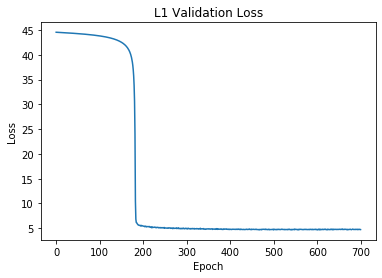

In [52]:
plt.title('L1 Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(losses)
plt.show()

## Model Evaluation

In [75]:
def score(
        model: nn.Sequential, 
        bet: str, 
        category: str,
        buffer: float=1,
) -> Tuple[int, int, int]:
    """
    This function handles some preliminary data loading tasks before redirecting to 
    the more specific _score_spread() and _score_overunder() functions.
    
    Parameters:
        model: The ANN object with learned parameters
        bet: Either 'spread' or 'over/under'
        category: Either 'open' or 'close'
        buffer: How much our model must contradict the odds to place a bet.
                Otherwise we just 'push' and don't take any action.
        
    Returns:
        A three-tuple consisting of (bets won, bets lost, bets pushed)
    """
    if buffer < 0:
        raise RuntimeError(f'{buffer=} makes no sense')
        
    if category not in {'open', 'close'}:
        raise RuntimeError(f"{category=} not valid, must be in ['open', 'close']")
    
    i_t, x_test, y_test = load_model_data('test')
    y_predicted = model(x_test)
    
    # pd.Series are way easier to handle than tensors
    y_hat = pd.Series(y_predicted.detach().squeeze(), index=i_t)
    y = pd.Series(y_test.detach().squeeze(), index=i_t)

    odds = load_odds_data('test').dropna()
    intersection = odds.index.intersection(i_t)

    # Drop some games, since our prepared NBA data doesn't contain
    # every game in the season.
    odds = odds.loc[intersection]
    y_hat = y_hat.loc[intersection]
    y = y.loc[intersection]
    
    # Check that both data sources agree on the points scored
    assert (y == odds['pts']).all()

    if bet == 'over/under':
        return _score_overunder(model, odds[f'ou_{category}'], 
                                y, y_hat, buffer)
    
    elif bet == 'spread':
        return _score_spread(model, odds[f'spread_{category}'], 
                             y, y_hat, buffer)
        
    else:
        msg = f"{bet=} not valid, must be in ['over/under', 'spread']"
        raise RuntimeError(msg)

In [113]:
def _score_spread(
        model: nn.Sequential, 
        odds: pd.Series, 
        y: pd.Series, 
        y_hat: pd.Series,
        buffer: float
) -> Tuple[int, int, int]:
    """
    Given a 'buffer', determine how many 'spread' bets we would have
    placed and won.
    
    Parameters:
        model: ANN with trained model parameters
        odds: A slice of the original df with either 'open' or 'close'
        y: Actual score outcomes per team
        y_hat: Predicted score outcomes per team
        buffer: A measure of how much our model must contradict the odds
                in order to place a bet.
                
    Returns:
        A three-tuple consisting of (games won, games lost, no action taken)
    """
    # We need to divided be -2 here because the favorite is always given a negative
    # spread, but we actually want a positive difference with the opponent
    bookie = odds.groupby(level='GAME_ID').diff().dropna() / -2
    actual_spreads = y.groupby(level='GAME_ID').diff().dropna()
    model_spreads = y_hat.groupby(level='GAME_ID').diff().dropna()
    
    long = model_spreads - buffer > bookie
    won_long = long & (actual_spreads > bookie)
    
    short = model_spreads + buffer < bookie
    won_short = short & (actual_spreads < bookie)
    
    push = ~long & ~short
    
    won = won_long.sum() + won_short.sum()
    lost = long.sum() + short.sum() - won
    pushed = push.sum()
    
    return won, lost, pushed

In [79]:
def _score_overunder(
        model: nn.Sequential, 
        odds: pd.Series, 
        y: pd.Series, 
        y_hat: pd.Series,
        buffer: float
) -> Tuple[int, int, int]:
    """
    Given a 'buffer', determine how many over/under bets we would have
    placed and won.
    
    Parameters:
        model: ANN with trained model parameters
        odds: A slice of the original df with either 'open' or 'close'
        y: Actual score outcomes per team
        y_hat: Predicted score outcomes per team
        buffer: A measure of how much our model must contradict the odds
                in order to place a bet.
                
    Returns:
        A three-tuple consisting of (games won, games lost, no action taken)
    """
    bookie = odds.groupby(level='GAME_ID').first()
    actual_totals = y.groupby(level='GAME_ID').sum()
    model_totals = y_hat.groupby(level='GAME_ID').sum()
    
    long = model_totals + buffer < bookie
    won_long = long & (actual_totals < bookie)
    
    short = model_totals - buffer > bookie
    won_short = short & (actual_totals > bookie)
    
    push = ~long & ~short
    
    won = won_long.sum() + won_short.sum()
    lost = long.sum() + short.sum() - won
    pushed = push.sum()
    
    return won, lost, pushed

In [101]:
# OVER/UNDER results at the CLOSE
header = '\t b won lost push  win% push%'
print(header)
print( '\t' + '-' * len(header))
for b in range(0, 50, 2):
    won, lost, pushed = score(model, 'over/under', 'close', b)
    win_pct = won / (won + lost)
    push_pct = pushed / (won + lost + pushed)
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 473  523    0 0.475 0.000
	 2 449  499   48 0.474 0.048
	 4 423  462  111 0.478 0.111
	 6 389  429  178 0.476 0.179
	 8 351  395  250 0.471 0.251
	10 320  349  327 0.478 0.328
	12 276  300  420 0.479 0.422
	14 237  254  505 0.483 0.507
	16 210  210  576 0.500 0.578
	18 172  166  658 0.509 0.661
	20 135  133  728 0.504 0.731
	22 107  104  785 0.507 0.788
	24  81   76  839 0.516 0.842
	26  59   56  881 0.513 0.885
	28  47   40  909 0.540 0.913
	30  31   25  940 0.554 0.944
	32  23   19  954 0.548 0.958
	34  14    8  974 0.636 0.978
	36  10    5  981 0.667 0.985
	38   7    4  985 0.636 0.989
	40   4    1  991 0.800 0.995
	42   2    1  993 0.667 0.997
	44   1    1  994 0.500 0.998
	46   1    0  995 1.000 0.999
	48   1    0  995 1.000 0.999


In [102]:
# OVER/UNDER results at the OPEN
header = '\t b won lost push  win% push%'
print(header)
print('\t' + '-' * len(header))
for b in range(0, 50, 2):
    won, lost, pushed = score(model, 'over/under', 'open', b)
    win_pct = won / (won + lost)
    push_pct = pushed / (won + lost + pushed)
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 476  520    0 0.478 0.000
	 2 461  488   47 0.486 0.047
	 4 433  453  110 0.489 0.110
	 6 399  417  180 0.489 0.181
	 8 370  386  240 0.489 0.241
	10 325  340  331 0.489 0.332
	12 279  296  421 0.485 0.423
	14 250  244  502 0.506 0.504
	16 209  192  595 0.521 0.597
	18 181  151  664 0.545 0.667
	20 143  125  728 0.534 0.731
	22 112  103  781 0.521 0.784
	24  89   75  832 0.543 0.835
	26  70   53  873 0.569 0.877
	28  48   34  914 0.585 0.918
	30  39   21  936 0.650 0.940
	32  31   14  951 0.689 0.955
	34  19    9  968 0.679 0.972
	36  15    4  977 0.789 0.981
	38  12    3  981 0.800 0.985
	40  10    1  985 0.909 0.989
	42   6    1  989 0.857 0.993
	44   5    1  990 0.833 0.994
	46   4    0  992 1.000 0.996
	48   3    0  993 1.000 0.997


In [116]:
# SPREAD results at the CLOSE
header = '\t b won lost push  win% push%'
print(header)
print( '\t' + '-' * len(header))
for b in range(0, 30, 2):
    won, lost, pushed = score(model, 'spread', 'close', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 477  519    0 0.479 0.000
	 2 379  424  193 0.472 0.194
	 4 280  329  387 0.460 0.389
	 6 205  238  553 0.463 0.555
	 8 144  163  689 0.469 0.692
	10  97  108  791 0.473 0.794
	12  60   56  880 0.517 0.884
	14  40   38  918 0.513 0.922
	16  26   23  947 0.531 0.951
	18  13   11  972 0.542 0.976
	20   6    6  984 0.500 0.988
	22   2    2  992 0.500 0.996
	24   2    1  993 0.667 0.997
	26   1    1  994 0.500 0.998
	28   0    1  995 0.000 0.999
	30   0    1  995 0.000 0.999
	32   0    1  995 0.000 0.999
	34   0    1  995 0.000 0.999
	36   0    1  995 0.000 0.999
	38   0    1  995 0.000 0.999
	40   0    1  995 0.000 0.999
	42   0    0  996 0.000 1.000
	44   0    0  996 0.000 1.000
	46   0    0  996 0.000 1.000
	48   0    0  996 0.000 1.000


In [117]:
# SPREAD results at the OPEN
header = '\t b won lost push  win% push%'
print(header)
print( '\t' + '-' * len(header))
for b in range(0, 30, 2):
    won, lost, pushed = score(model, 'spread', 'open', b)
    win_pct = won / (won + lost) if won + lost else 0
    push_pct = pushed / (won + lost + pushed)
    print(f'\t{b:>2}{won:>4}{lost:>5}{pushed:>5} {win_pct:.3f} {push_pct:.3f}')

	 b won lost push  win% push%
	-----------------------------
	 0 482  514    0 0.484 0.000
	 2 388  411  197 0.486 0.198
	 4 283  323  390 0.467 0.392
	 6 212  230  554 0.480 0.556
	 8 150  152  694 0.497 0.697
	10  93   98  805 0.487 0.808
	12  65   54  877 0.546 0.881
	14  44   34  918 0.564 0.922
	16  23   25  948 0.479 0.952
	18  17   12  967 0.586 0.971
	20   9    6  981 0.600 0.985
	22   4    2  990 0.667 0.994
	24   3    1  992 0.750 0.996
	26   2    1  993 0.667 0.997
	28   2    1  993 0.667 0.997


## Open Questions

* Would directly predicted spreads or over/unders work better?
* Can attention layers help learn the interactions of different players on the court
* What other features would prove helpful?